In [2]:
# Project paths (booking pipeline)
from pathlib import Path
import sys

def find_repo_root(start: Path) -> Path:
    for p in [start] + list(start.parents):
        if (p / "pyproject.toml").exists() and (p / "src" / "airline_revenue_analytics").exists():
            return p
    return start

REPO_ROOT = find_repo_root(Path.cwd())
PROJECT_ROOT = REPO_ROOT
SRC_ROOT = REPO_ROOT / "src"
if str(SRC_ROOT) not in sys.path:
    sys.path.append(str(SRC_ROOT))

from airline_revenue_analytics.config import get_paths

PATHS = get_paths("booking")
DATA_DIR = REPO_ROOT / "data"
RAW_DIR = PATHS.data_raw
DB_PATH = PATHS.db_path
OUTPUT_DIR = PATHS.outputs_root
FIG_DIR = PATHS.figures
TAB_DIR = PATHS.tables
ART_DIR = PATHS.artifacts

def _rel(p: Path) -> str:
    try:
        return str(Path(p).resolve().relative_to(REPO_ROOT))
    except Exception:
        return Path(p).name

print("REPO_ROOT:", REPO_ROOT.name)
print("DB_PATH:", _rel(DB_PATH))
print("OUTPUT_DIR:", _rel(OUTPUT_DIR))


REPO_ROOT: airline-revenue-analytics
DB_PATH: data/raw/airlines_db.sqlite
OUTPUT_DIR: outputs/booking


# 06 - Interpretation & Comparison (Step 8)
Goal: compare Loop A vs Loop B, analyze errors by buckets, and summarize insights.
All outputs are saved under `outputs/booking/tables/` and `outputs/booking/figures/`.
Requires `table_7_1_predictions_loopA.csv` and `table_7_1_predictions_loopB.csv` from notebooks 04/05.


In [3]:
# Imports & paths
import sys, pathlib, numpy as np, pandas as pd
import matplotlib; import matplotlib.pyplot as plt

# ensure "src" importable when running from notebooks/
sys.path.append(str(PROJECT_ROOT))



OUT_DIR = OUTPUT_DIR
FIG_DIR = OUT_DIR / "figures"
TAB_DIR = OUT_DIR / "tables"

print("FIG_DIR:", _rel(FIG_DIR))
print("TAB_DIR:", _rel(TAB_DIR))


FIG_DIR: outputs/booking/figures
TAB_DIR: outputs/booking/tables


In [4]:
from airline_revenue_analytics.viz.charts import apply_style, PLOT_COLORS
apply_style()
PASS_COLOR = "#D9F2E6"
FAIL_COLOR = "#FCE4E4"
NEG_BG_COLOR = FAIL_COLOR


In [5]:
# Load booking-level dataset (for joining buckets)
df = pd.read_parquet(TAB_DIR / "booking_model_df.parquet").copy()

# --- Loop A/B predictions ---
predA_path = TAB_DIR / "table_7_1_predictions_loopA.csv"
predB_path = TAB_DIR / "table_7_1_predictions_loopB.csv"
missing = [p for p in (predA_path, predB_path) if not p.exists()]
if missing:
    missing_str = ", ".join([str(p) for p in missing])
    raise FileNotFoundError(
        "Missing prediction tables: "
        f"{missing_str}. Run notebooks/booking/04_modeling_loopA.ipynb and "
        "notebooks/booking/05_modeling_loopB.ipynb to generate them."
    )

# --- Loop A predictions ---
predA = pd.read_csv(predA_path)
# Ensure expected columns exist
need_cols_A = {"book_ref","y_true"}
assert need_cols_A.issubset(set(predA.columns)), f"Loop A file missing columns: {need_cols_A - set(predA.columns)}"

# Detect both prediction columns (Linear & Tree)
predA_cols = [c for c in predA.columns if c.startswith("y_pred_") and c.endswith(("", "_loopA", ""))]
# Typical names: y_pred_linear, y_pred_tree
assert len(predA_cols) >= 1, "Loop A file has no prediction columns (y_pred_*)"
predA_cols

# --- Loop B predictions (best model only) ---
predB = pd.read_csv(predB_path)
need_cols_B = {"book_ref","y_true"}
assert need_cols_B.issubset(set(predB.columns)), f"Loop B file missing columns: {need_cols_B - set(predB.columns)}"
# Detect the single y_pred_*_loopB column
predB_cols = [c for c in predB.columns if c.startswith("y_pred_") and c.endswith("_loopB")]
assert len(predB_cols) == 1, "Loop B file should have exactly one y_pred_*_loopB column"
colB = predB_cols[0]

# --- pick Loop A best (RMSE) among available predictors ---
def rmse(a, b):
    a = np.asarray(a).ravel(); b = np.asarray(b).ravel()
    return float(((a - b)**2).mean() ** 0.5)

scoresA = []
for c in predA_cols:
    scoresA.append((c, rmse(predA["y_true"], predA[c])))
scoresA = sorted(scoresA, key=lambda x: x[1])
bestA_col, bestA_rmse = scoresA[0]
bestA_col, bestA_rmse, scoresA[:3]


('y_pred_tree',
 0.3298483086023574,
 [('y_pred_tree', 0.3298483086023574), ('y_pred_linear', 0.39891162619439874)])

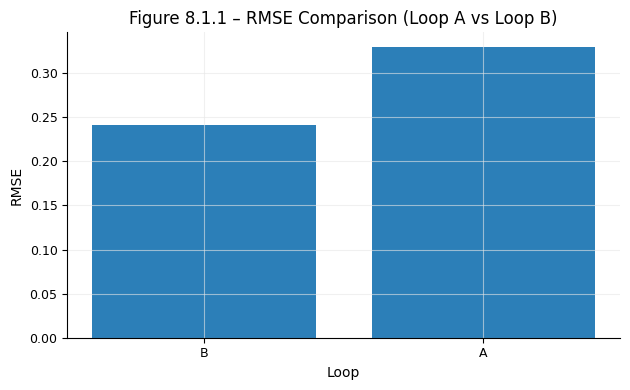

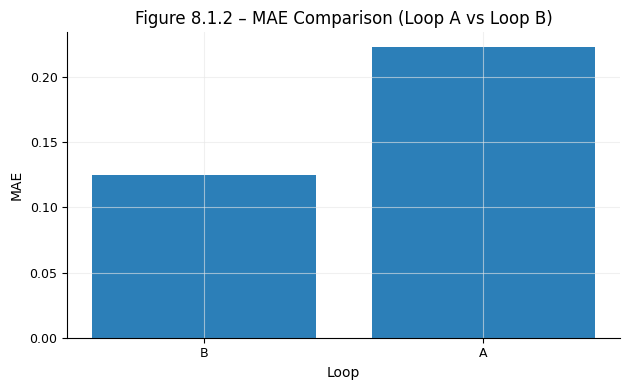

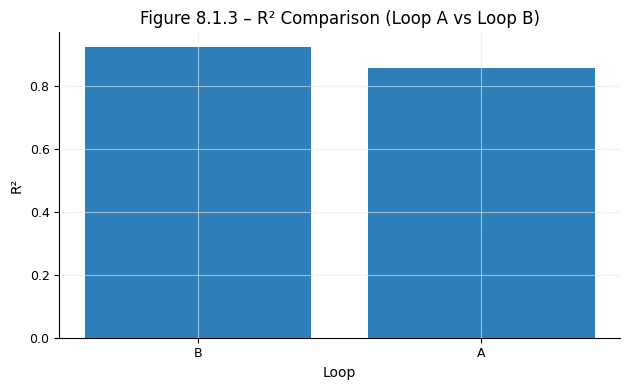

In [6]:
# Merge Loop A(best) & Loop B to a single comparable frame
comp = predA[["book_ref","y_true", bestA_col]].merge(
    predB[["book_ref", colB]], on="book_ref", how="inner", validate="one_to_one"
).rename(columns={bestA_col: "y_pred_loopA", colB: "y_pred_loopB"})

# ---- FIX: re-create 'primary_route_code_top' inside this notebook ----
# booking_model_df.parquet 里没有这个列；这里用与 03/04 相同的 top-K 规则重建
if "primary_route_code_top" not in df.columns:
    if "primary_route_code" in df.columns:
        split_path = TAB_DIR / "table_4_3_1_split_ids.csv"
        if not split_path.exists():
            raise FileNotFoundError(
                f"Missing split file: {split_path}. Run notebooks/booking/03_transformation_and_split.ipynb."
            )
        split_ids = pd.read_csv(split_path)
        if "index" in split_ids.columns:
            idx_train = split_ids.loc[split_ids["split"].eq("train"), "index"].to_numpy()
        else:
            idx_map = df.reset_index()[["index", "book_ref"]]
            merged = split_ids.merge(idx_map, on="book_ref", how="left", validate="one_to_one")
            idx_train = merged.loc[merged["split"].eq("train"), "index"].to_numpy()

        cat_raw = df["primary_route_code"].astype("string").fillna("Unknown")
        top_k = 20
        top_routes = cat_raw.loc[idx_train].value_counts().index[:top_k].tolist()
        df["primary_route_code_top"] = np.where(cat_raw.isin(top_routes), cat_raw, "Other")
    else:
        # 极端兜底：如果连 primary_route_code 都没有，就全设 Unknown（不会影响其他分析）
        df["primary_route_code_top"] = "Unknown"

# Attach useful buckets from df for analysis
keep_cols = [
    "book_ref",
    "n_segments","has_longhaul","max_cabin_index","share_premium_cabin",
    "primary_route_code_top","avg_booking_lead_days","total_amount","log_total_amount"
]
comp = comp.merge(df[keep_cols], on="book_ref", how="left", validate="one_to_one")

# Compute metrics for Loop A vs Loop B
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def eval_series(y_true, y_pred):
    y_true = np.asarray(y_true).ravel(); y_pred = np.asarray(y_pred).ravel()
    r2  = float(r2_score(y_true, y_pred))
    try:
        rmse = float(mean_squared_error(y_true, y_pred, squared=False))
    except TypeError:
        rmse = float(mean_squared_error(y_true, y_pred) ** 0.5)
    mae = float(mean_absolute_error(y_true, y_pred))
    return {"R2": r2, "RMSE": rmse, "MAE": mae}

mA = {"loop":"A", **eval_series(comp["y_true"], comp["y_pred_loopA"])}
mB = {"loop":"B", **eval_series(comp["y_true"], comp["y_pred_loopB"])}
compare_tbl = pd.DataFrame([mA, mB]).sort_values("RMSE")
compare_tbl.to_csv(TAB_DIR/"table_8_1_model_compare.csv", index=False)
compare_tbl

# --- plots: RMSE / MAE / R2 side-by-side (each in its own figure) ---
plt.figure()
plt.bar(compare_tbl["loop"], compare_tbl["RMSE"])
plt.title("Figure 8.1.1 – RMSE Comparison (Loop A vs Loop B)")
plt.xlabel("Loop"); plt.ylabel("RMSE")
plt.tight_layout(); plt.savefig(FIG_DIR/"figure_8_1_1_rmse_compare.png", dpi=150); plt.show()

plt.figure()
plt.bar(compare_tbl["loop"], compare_tbl["MAE"])
plt.title("Figure 8.1.2 – MAE Comparison (Loop A vs Loop B)")
plt.xlabel("Loop"); plt.ylabel("MAE")
plt.tight_layout(); plt.savefig(FIG_DIR/"figure_8_1_2_mae_compare.png", dpi=150); plt.show()

plt.figure()
plt.bar(compare_tbl["loop"], compare_tbl["R2"])
plt.title("Figure 8.1.3 – R² Comparison (Loop A vs Loop B)")
plt.xlabel("Loop"); plt.ylabel("R²")
plt.tight_layout(); plt.savefig(FIG_DIR/"figure_8_1_3_r2_compare.png", dpi=150); plt.show()


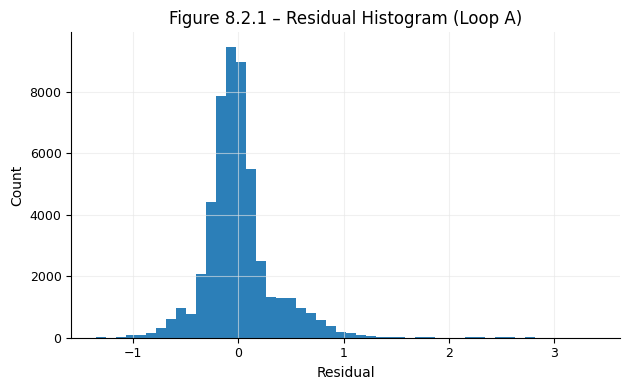

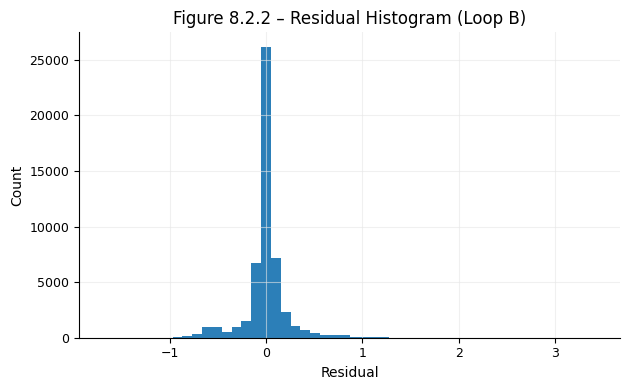

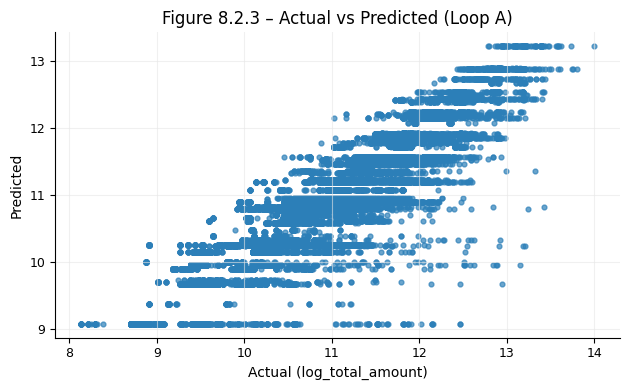

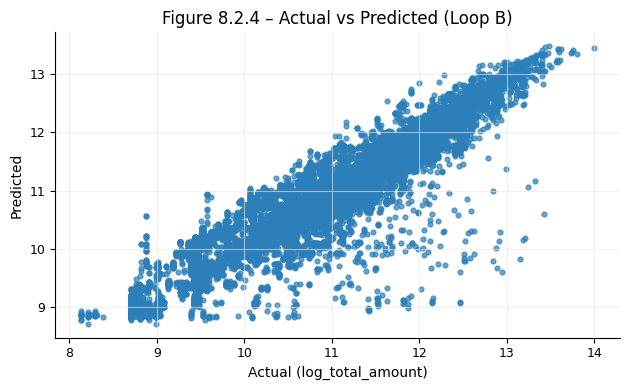

In [7]:
# Residuals
resA = comp["y_true"] - comp["y_pred_loopA"]
resB = comp["y_true"] - comp["y_pred_loopB"]

# Residual histogram – Loop A
plt.figure()
plt.hist(resA.dropna(), bins=50)
plt.title("Figure 8.2.1 – Residual Histogram (Loop A)")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(FIG_DIR/"figure_8_2_1_residual_hist_loopA.png", dpi=150); plt.show()

# Residual histogram – Loop B
plt.figure()
plt.hist(resB.dropna(), bins=50)
plt.title("Figure 8.2.2 – Residual Histogram (Loop B)")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(FIG_DIR/"figure_8_2_2_residual_hist_loopB.png", dpi=150); plt.show()

# Actual vs Predicted – Loop A
plt.figure()
plt.scatter(comp["y_true"], comp["y_pred_loopA"], s=12, alpha=0.7)
plt.title("Figure 8.2.3 – Actual vs Predicted (Loop A)")
plt.xlabel("Actual (log_total_amount)"); plt.ylabel("Predicted")
plt.tight_layout(); plt.savefig(FIG_DIR/"figure_8_2_3_actual_vs_pred_loopA.png", dpi=150); plt.show()

# Actual vs Predicted – Loop B
plt.figure()
plt.scatter(comp["y_true"], comp["y_pred_loopB"], s=12, alpha=0.7)
plt.title("Figure 8.2.4 – Actual vs Predicted (Loop B)")
plt.xlabel("Actual (log_total_amount)"); plt.ylabel("Predicted")
plt.tight_layout(); plt.savefig(FIG_DIR/"figure_8_2_4_actual_vs_pred_loopB.png", dpi=150); plt.show()


/var/folders/_g/cmqkvs694c7g4rmksh2jd5hr0000gn/T/ipykernel_9907/4109846973.py:37: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(index="bucket", columns="loop", values="RMSE")


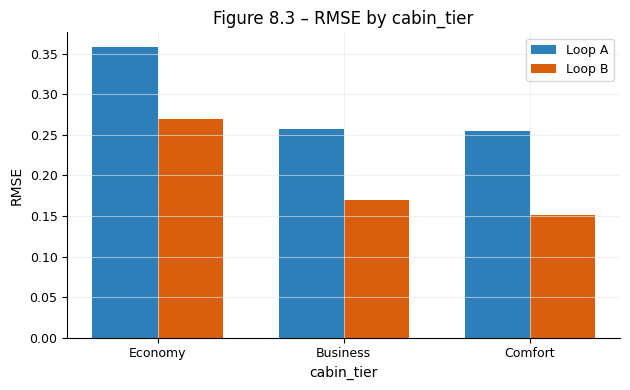

/var/folders/_g/cmqkvs694c7g4rmksh2jd5hr0000gn/T/ipykernel_9907/4109846973.py:37: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(index="bucket", columns="loop", values="RMSE")


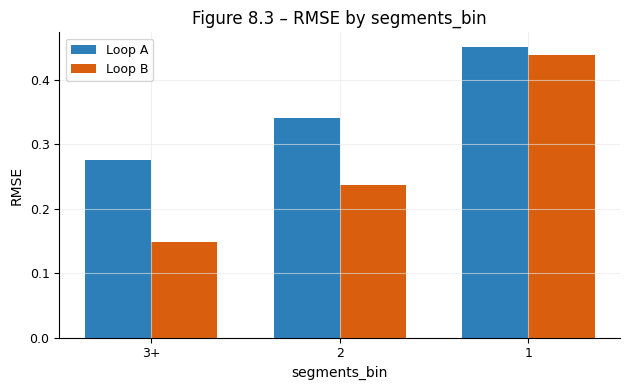

/var/folders/_g/cmqkvs694c7g4rmksh2jd5hr0000gn/T/ipykernel_9907/4109846973.py:37: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = sub.pivot_table(index="bucket", columns="loop", values="RMSE")


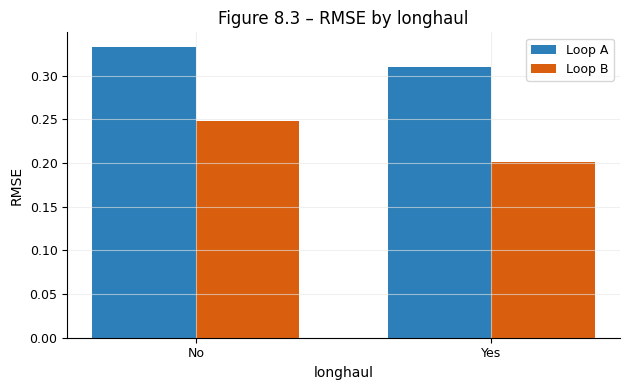

In [8]:
# Build bucket labels
comp["cabin_tier"] = comp["max_cabin_index"].map({0:"Economy", 1:"Comfort", 2:"Business"}).fillna("Unknown")
comp["segments_bin"] = np.where(comp["n_segments"] >= 3, "3+", comp["n_segments"].fillna(0).astype(int).astype(str))
comp["longhaul"] = comp["has_longhaul"].map({0:"No", 1:"Yes"}).fillna("Unknown")

# helper to compute per-bucket metrics for both loops
def bucket_metrics(df, bucket_col, top_only=False, top_n=5):
    rows = []
    cats = df[bucket_col].value_counts().index.tolist()
    if top_only:
        cats = cats[:top_n]
        df = df[df[bucket_col].isin(cats)].copy()
    for c in cats:
        sub = df[df[bucket_col] == c]
        if len(sub) < 5:
            continue
        mA = eval_series(sub["y_true"], sub["y_pred_loopA"])
        mB = eval_series(sub["y_true"], sub["y_pred_loopB"])
        rows.append((bucket_col, c, "A", len(sub), mA["RMSE"], mA["MAE"], mA["R2"]))
        rows.append((bucket_col, c, "B", len(sub), mB["RMSE"], mB["MAE"], mB["R2"]))
    return pd.DataFrame(rows, columns=["bucket_type","bucket","loop","n","RMSE","MAE","R2"])

# Compute bucket tables
bm_cabin = bucket_metrics(comp, "cabin_tier")
bm_seg   = bucket_metrics(comp, "segments_bin")
bm_lh    = bucket_metrics(comp, "longhaul")
bm_all = pd.concat([bm_cabin, bm_seg, bm_lh], ignore_index=True)
bm_all.to_csv(TAB_DIR/"table_8_2_error_by_bucket.csv", index=False)
bm_all.head(10)

# Plot RMSE by bucket for each bucket_type (bar, side-by-side)
def plot_bucket_rmse(bm, bucket_type, outfile):
    sub = bm[bm["bucket_type"] == bucket_type].copy()
    # sort buckets by total n descending
    order = (sub.groupby("bucket")["n"].sum().sort_values(ascending=False)).index.tolist()
    sub["bucket"] = pd.Categorical(sub["bucket"], categories=order, ordered=True)
    pivot = sub.pivot_table(index="bucket", columns="loop", values="RMSE")
    plt.figure()
    # since no seaborn: draw two bars per x manually
    x = np.arange(len(pivot.index))
    width = 0.35
    plt.bar(x - width/2, pivot["A"].values, width, label="Loop A")
    plt.bar(x + width/2, pivot["B"].values, width, label="Loop B")
    plt.xticks(x, pivot.index, rotation=0)
    plt.title(f"Figure 8.3 – RMSE by {bucket_type}")
    plt.xlabel(bucket_type); plt.ylabel("RMSE")
    plt.legend()
    plt.tight_layout(); plt.savefig(outfile, dpi=150); plt.show()

plot_bucket_rmse(bm_all, "cabin_tier",   FIG_DIR/"figure_8_3_1_bucket_cabin_rmse_compare.png")
plot_bucket_rmse(bm_all, "segments_bin", FIG_DIR/"figure_8_3_2_bucket_segments_rmse_compare.png")
plot_bucket_rmse(bm_all, "longhaul",     FIG_DIR/"figure_8_3_3_bucket_longhaul_rmse_compare.png")


/var/folders/_g/cmqkvs694c7g4rmksh2jd5hr0000gn/T/ipykernel_9907/2941216711.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for d, sub in valid.groupby("decile"):


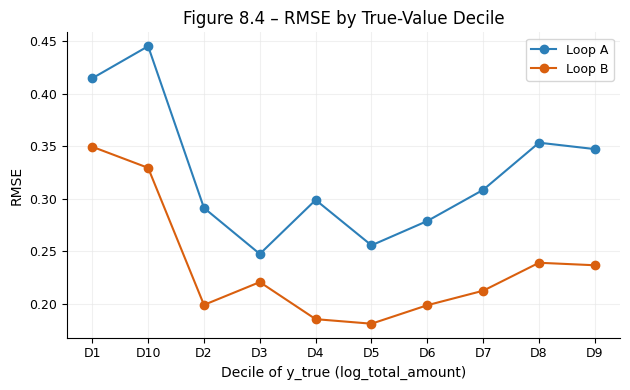

In [9]:
# Decile-by-true analysis
valid = comp.dropna(subset=["y_true","y_pred_loopA","y_pred_loopB"]).copy()
valid["decile"] = pd.qcut(valid["y_true"], 10, labels=[f"D{i}" for i in range(1,11)])

dec_rows = []
for d, sub in valid.groupby("decile"):
    mA = eval_series(sub["y_true"], sub["y_pred_loopA"])
    mB = eval_series(sub["y_true"], sub["y_pred_loopB"])
    dec_rows.append((d, "A", mA["RMSE"], mA["MAE"], mA["R2"], len(sub)))
    dec_rows.append((d, "B", mB["RMSE"], mB["MAE"], mB["R2"], len(sub)))
dec_tbl = pd.DataFrame(dec_rows, columns=["decile","loop","RMSE","MAE","R2","n"]).sort_values(["decile","loop"])
dec_tbl.to_csv(TAB_DIR/"table_8_3_decile_metrics.csv", index=False)
dec_tbl.head(10)

# Plot: RMSE over deciles (two lines)
pivot = dec_tbl.pivot_table(index="decile", columns="loop", values="RMSE")
plt.figure()
plt.plot(pivot.index.astype(str), pivot["A"].values, marker="o", label="Loop A")
plt.plot(pivot.index.astype(str), pivot["B"].values, marker="o", label="Loop B")
plt.title("Figure 8.4 – RMSE by True-Value Decile")
plt.xlabel("Decile of y_true (log_total_amount)"); plt.ylabel("RMSE")
plt.legend()
plt.tight_layout(); plt.savefig(FIG_DIR/"figure_8_4_decile_rmse_compare.png", dpi=150); plt.show()


## Step 8 – Findings & Business Interpretation (Template)

**Model comparison (A vs B):**
- Loop A best vs Loop B: see `table_8_1_model_compare.csv` and Figures 8.1.1–8.1.3.
- Improvement: report relative RMSE↓/MAE↓ and R²↑.

**Error patterns (by buckets):**
- Cabin tier: cite `figure_8_3_1_bucket_cabin_rmse_compare.png` (e.g., premium cabins show higher/lower error).
- Segments count: cite `figure_8_3_2_bucket_segments_rmse_compare.png` (multi‑segment bookings harder?).
- Longhaul: cite `figure_8_3_3_bucket_longhaul_rmse_compare.png`.

**By value deciles:**
- Use `figure_8_4_decile_rmse_compare.png` to discuss under/over‑prediction across price bands.

**Actionable next steps:**
- (Data) Add features: route‑level historical yields, seasonality, booking channel, holiday flags.
- (Model) Try monotone constraints / regularisation; calibrate residuals by route & cabin.
- (Evaluation) Build cost‑sensitive metrics for high‑value bookings.

> Keep all figures/tables under `outputs/` for straightforward inclusion into the report.
